In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#hide
%load_ext autoreload
%autoreload 2

%matplotlib inline
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [3]:
__all__ ='ResBlock XResnet xresnet18 xresnet34 xresnet50 xresnet101 xresnet152'.split(" ")


In [4]:
#hide
# !git clone https://github.com/prajwal-suresh13/dl_lib.git

In [5]:
from dl_lib.core.utils import *
from dl_lib.core.models.basicmodels import *

# Resnet

- Stem is Resnet - C
- ResBlocks are Resnet-D with 3 conv layers for expansion 4 and 2 conv layers for expansion 1
- The first stage will have stride one for all blocks. The next stages will have stride 2 for only first block(for first conv in case of expansion is 1 and second conv in case of expansion 4).Rest of the blocks will have stride 1 
- conv(avgpool(x)) is added if stride is not equal to one

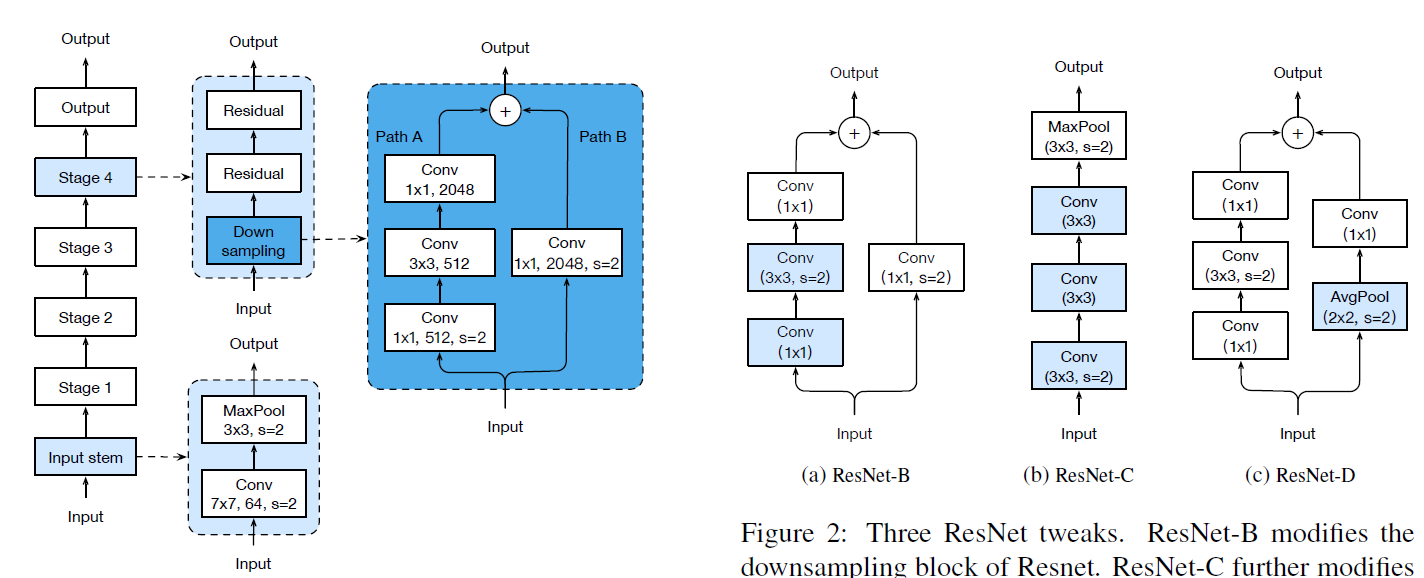

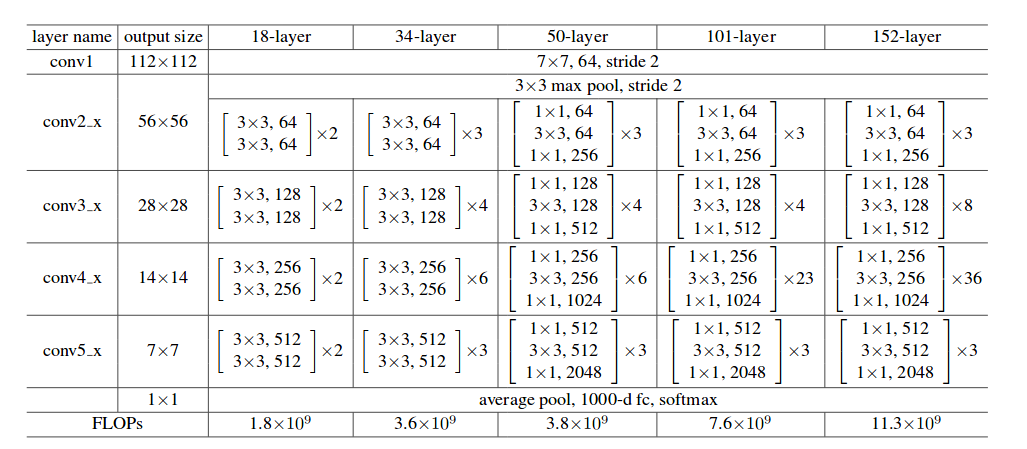

In [6]:
class ResBlock(nn.Module):
  def __init__(self,expansion, ni, nh, stride=1):
    super().__init__()
    ni, nf = ni*expansion, nh*expansion
    layers = [conv_layer(ni,nh, 3, stride=stride),
              conv_layer(nh, nf, 3, zero_bn=True, act=False)
            ] if expansion==1 else [
                conv_layer(ni,nh, 1),
                conv_layer(nh,nh,3, stride=stride),
                conv_layer(nh, nf, 1, zero_bn=True, act=False)
            ]

    self.convs = nn.Sequential(*layers)
    self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
    self.pool  = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

  def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))



In [7]:
class XResnet(nn.Sequential):
  @classmethod
  def create(cls, expansion, layers, c_in=3, c_out=1000):
    nfs = [c_in,(c_in+1)*8, 64,64]
    stem = [conv_layer(nfs[i], nfs[i+1], ks =3, stride=2 if i==0 else 1) for i in range(3)]

    nfs=[64//expansion, 64, 128, 256, 512]
    res_layers =[cls._make_layer(expansion, nfs[i], nfs[i+1], n_blocks=l, stride =1 if i==0 else 2) 
                for i,l in enumerate(layers)]

    res = cls(*stem,
              nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
              *res_layers,
              nn.AdaptiveAvgPool2d(1),
              Flatten(),
              nn.Linear(nfs[-1]*expansion, c_out)
              )
    
    kaiming_init_cnn(res)
    return res

  @staticmethod
  def _make_layer( expansion, ni, nf, n_blocks, stride):
    return nn.Sequential(
        *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
                          for i in range(n_blocks)])

In [8]:
def xresnet18(**kwargs): return XResnet.create(1, [2,2,2,2], **kwargs)
def xresnet34(**kwargs): return XResnet.create(1,[3,4,6,3], **kwargs)
def xresnet50(**kwargs): return XResnet.create(4, [3,4,6,3], **kwargs)
def xresnet101(**kwargs): return XResnet.create(4, [3,4,23,3], **kwargs)
def xresnet152(**kwargs): return XResnet.create(4, [ 3,8,36,3], **kwargs)

In [9]:
#hide
xresnet18(c_out=10)

XResnet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, mome

In [10]:
#hide
xresnet50(c_out=10)

XResnet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [11]:
#hide
!pip install fire
!python dl_lib/notebook2script.py notebooks/core/models/resnet.ipynb dl_lib/core/models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 7.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=d9b62281287277aed8dfcbcc2903df062fc88a1c7e5f3f4860ca9cb75049888e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Converted notebooks/core/models/resnet.ipynb to dl_lib/core/models/resnet.py
